In [53]:
from src.u_mamba import U_Mamba

In [28]:
channels = 3
hidden_size = 16
width = 16
height = 16
rank = 4
state_size = 4
kernel_size = 3

model = U_Mamba(channels=channels, width=width, height=height, hidden_size=hidden_size, rank=rank, state_size=state_size, kernel_size=kernel_size, num_layers=3)

In [33]:
train_dir = 'dataset/training'
test_dir = 'dataset/test'

import os
from PIL import Image

def load_data_from_directory(directory):
    image_list = []
    mask_list = []
    image_folder = os.path.join(directory, 'images')
    mask_folder = os.path.join(directory, 'mask_veins')
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

    for img_filename, mask_filename in zip(image_filenames, mask_filenames):
        if img_filename.endswith(".tif") and mask_filename.endswith(".gif"):
            img = Image.open(os.path.join(image_folder, img_filename))
            mask = Image.open(os.path.join(mask_folder, mask_filename))
            image_list.append(img)
            mask_list.append(mask)

    return image_list, mask_list

train_images, train_masks = load_data_from_directory(train_dir)
test_images, test_masks = load_data_from_directory(test_dir)

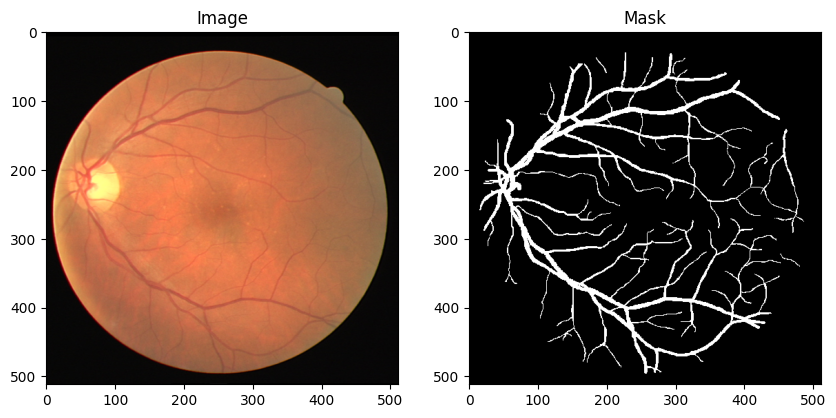

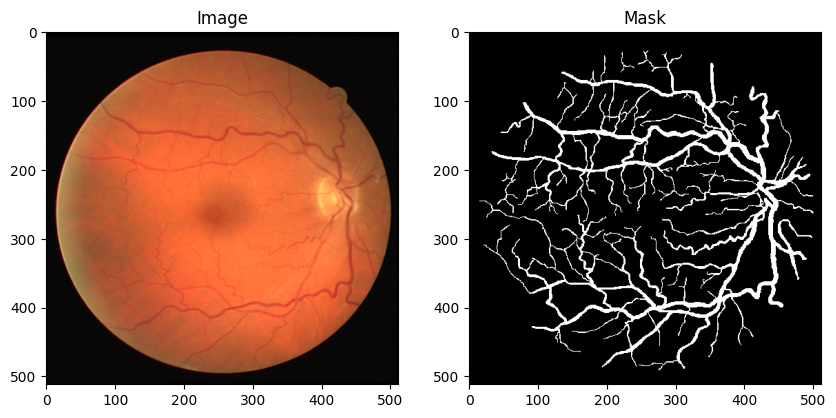

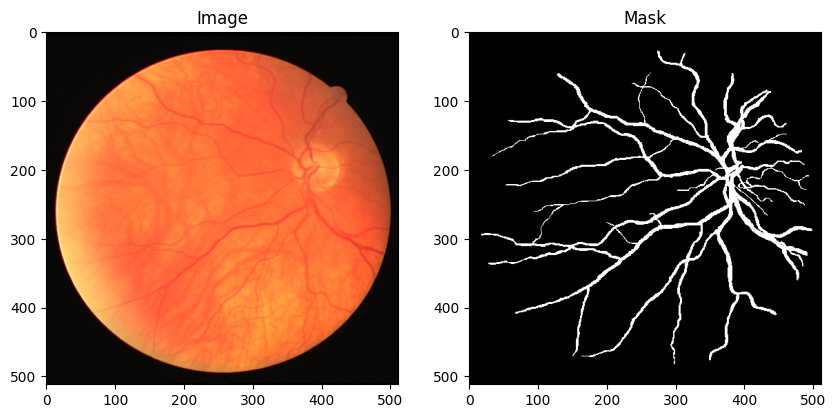

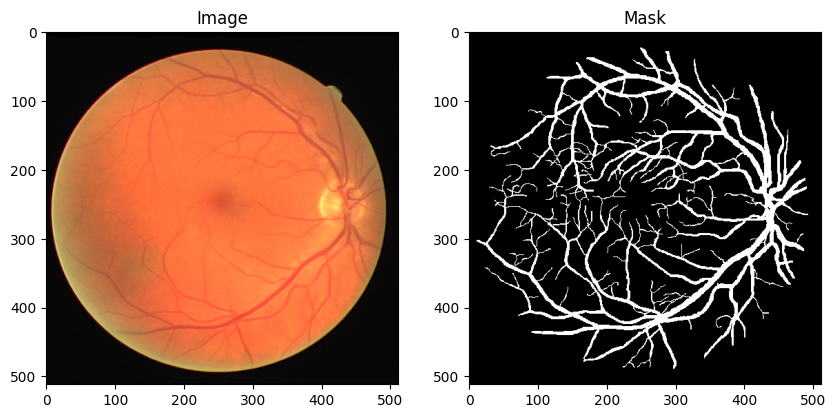

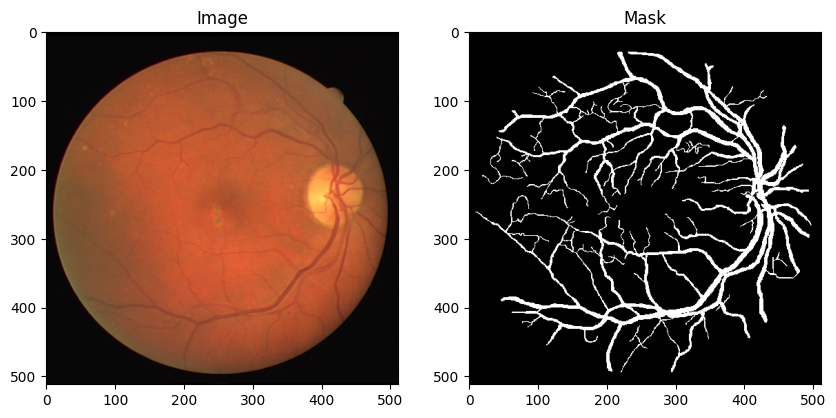

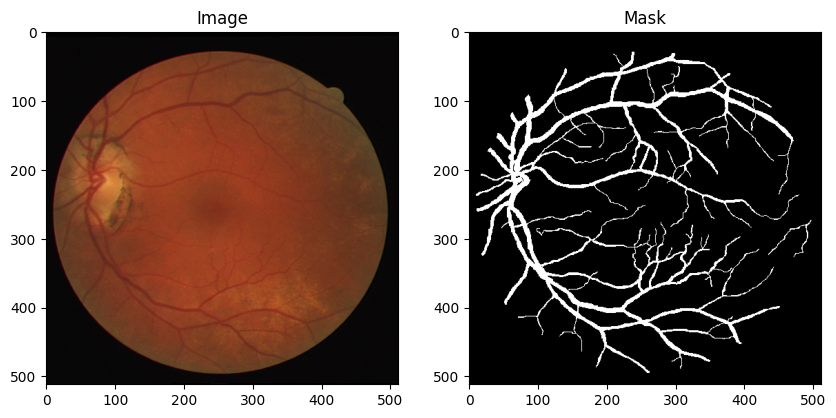

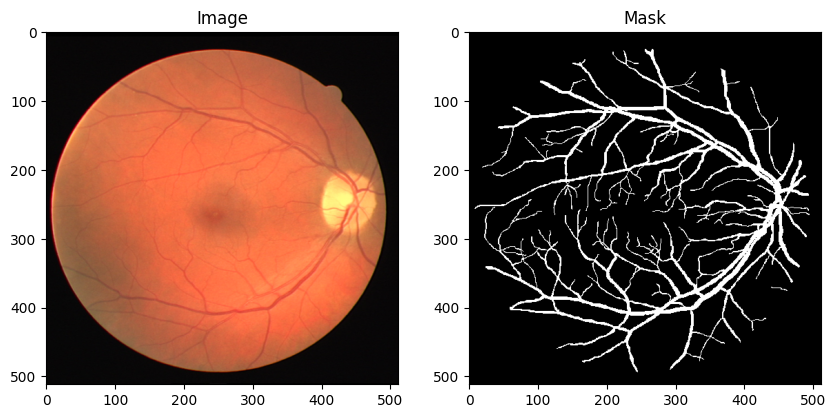

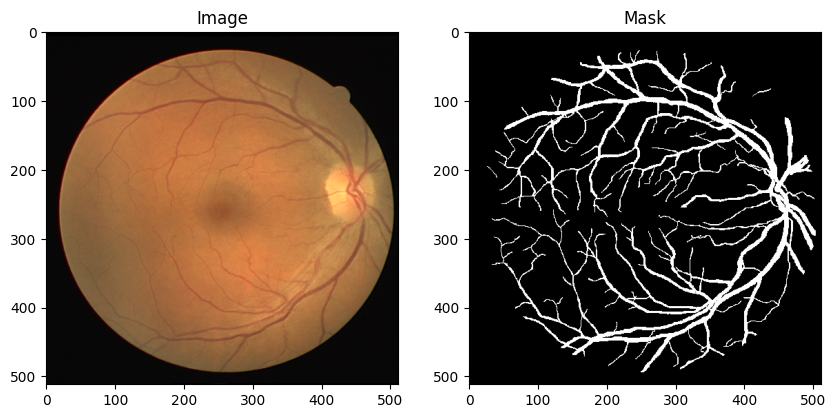

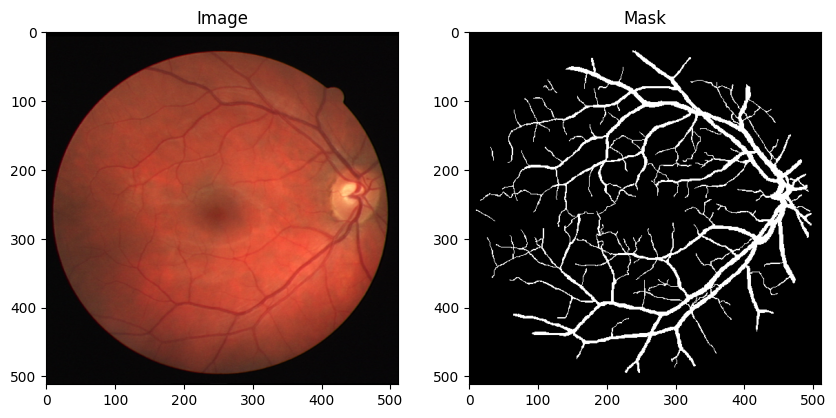

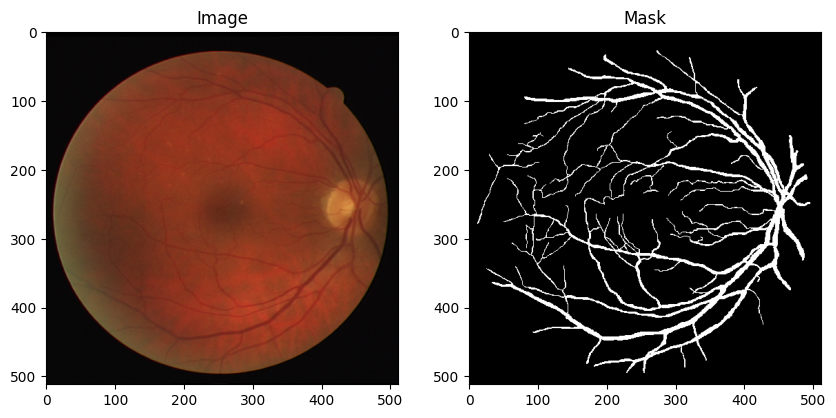

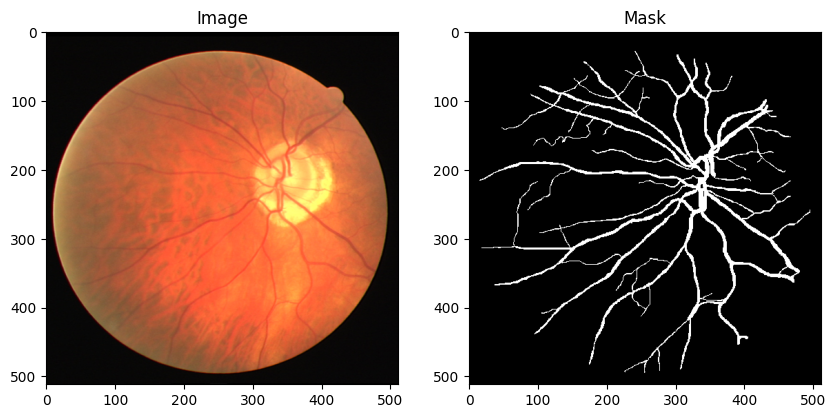

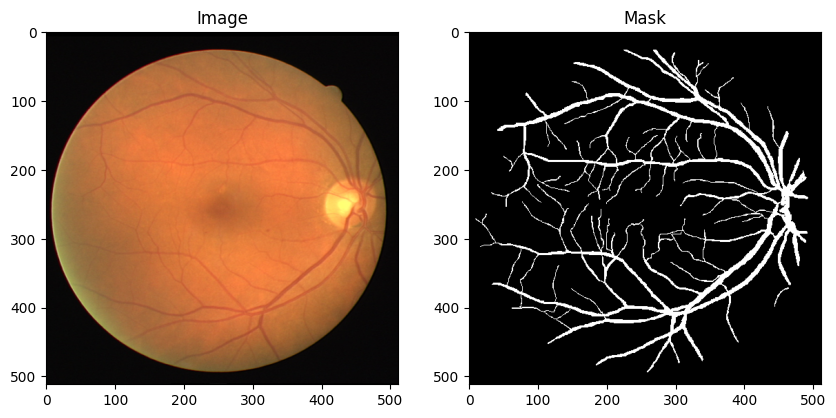

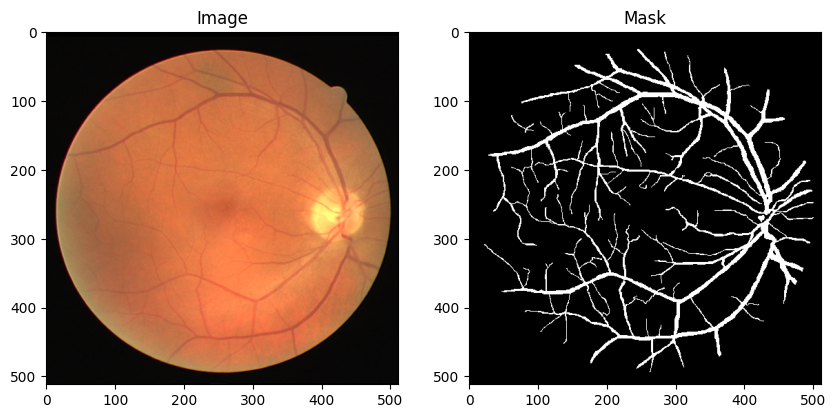

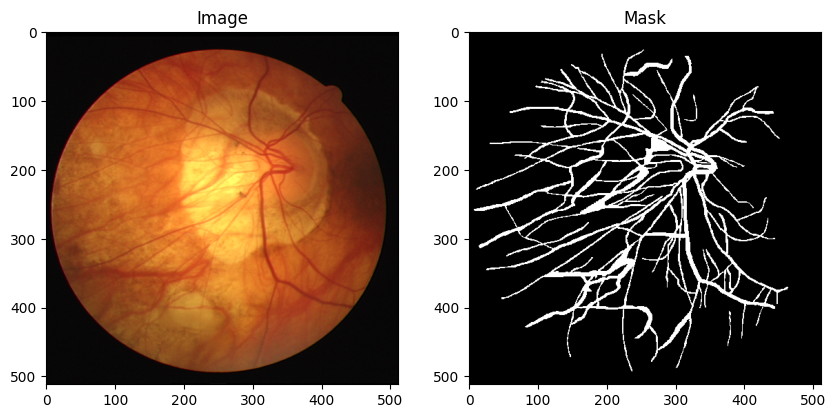

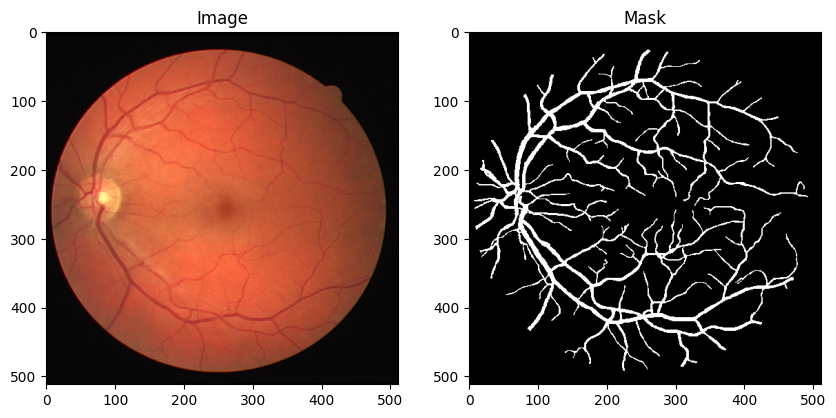

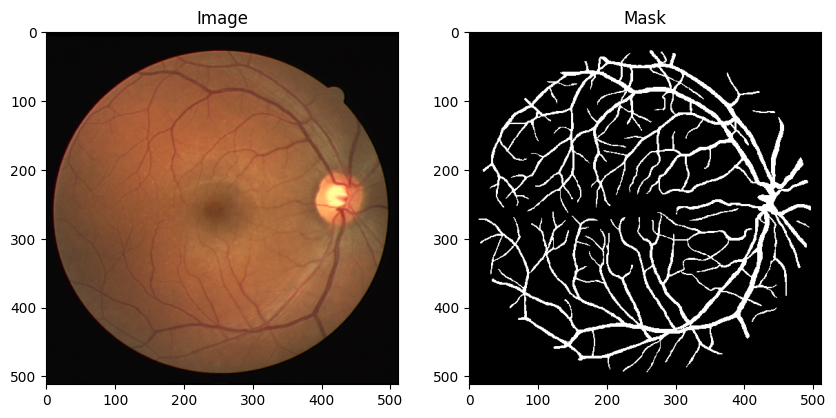

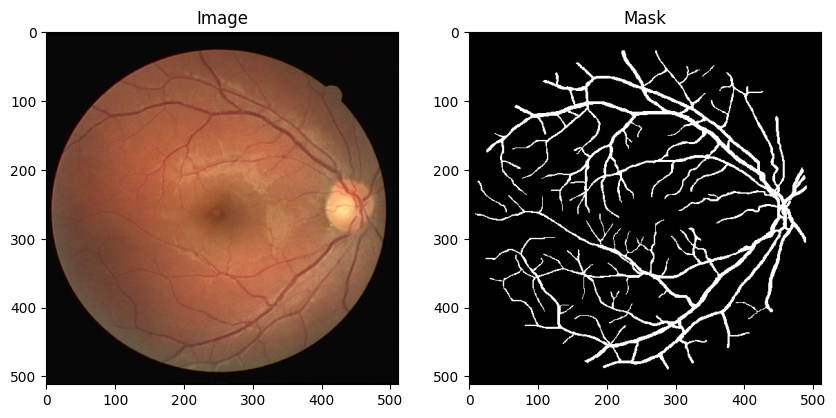

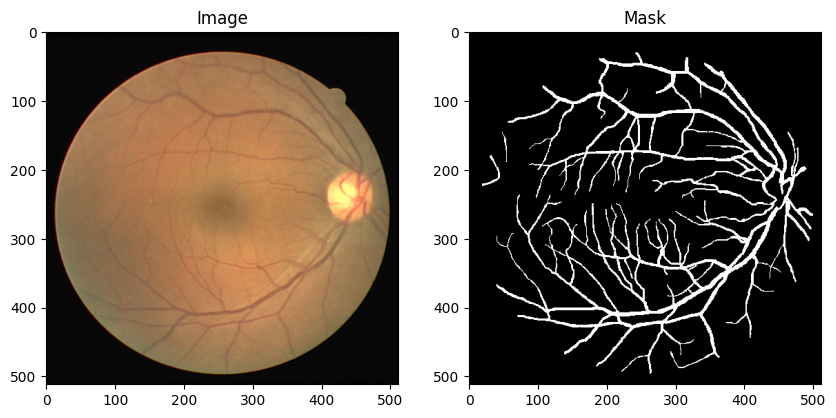

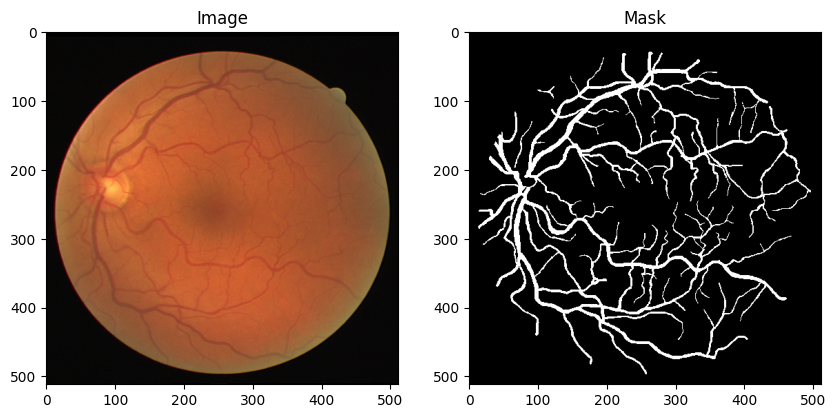

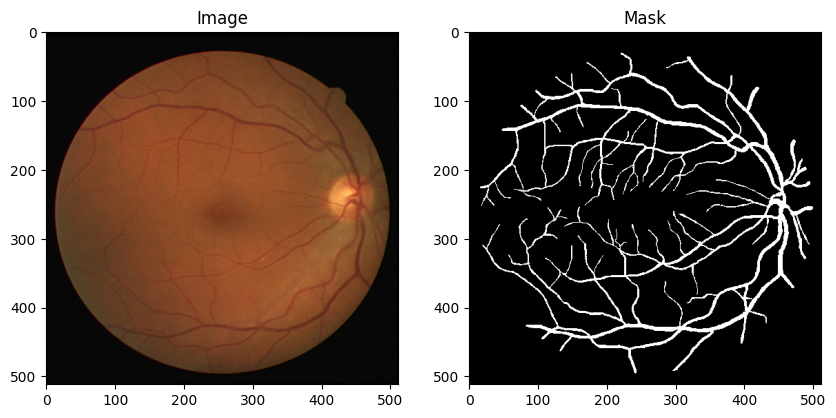

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess(images, masks):
    target_size = (512, 512)
    processed_images = []
    processed_masks = []

    for img, mask in zip(images, masks):

        mask_=np.array(mask)
        img_resized = img.resize(target_size, resample=Image.BILINEAR)
        mask_array = cv2.resize(mask_, target_size , interpolation=cv2.INTER_LINEAR)
        
        threshold_value = 70
        _,mask_array = cv2.threshold(mask_array, threshold_value, 255, cv2.THRESH_BINARY)
        img_array = np.array(img_resized)

        img_array = img_array.astype('float32') / 255.0
        
        mask_array = mask_array.astype('uint8') / 255

        processed_images.append(img_array)
        processed_masks.append(mask_array)

    return processed_images, processed_masks

train_images_processed, train_masks_processed = preprocess(train_images,train_masks)

for i in range(len(train_images_processed)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(train_images_processed[i], cmap='gray')
    ax[0].set_title('Image')
    
    ax[1].imshow(train_masks_processed[i], cmap='gray')
    ax[1].set_title('Mask')
    
    plt.show()

In [ ]:
import numpy as np
import torchvision

train_images_a = np.array(train_images_processed)
train_masks_a = np.array(train_masks_processed)
train_masks_a = np.repeat(train_masks_a[:, :, :, np.newaxis], 1, axis=-1)

def augment_data(images, masks, batch_size=16):
    seed = np.random.randint(1, 1000)

    #rewrite this with torchvision transforms
    image_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomRotation(15),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomAffine(15),
        torchvision.transforms.RandomResizedCrop(512),
        torchvision.transforms.ToTensor()
    ])

    mask_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomRotation(15),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomAffine(15),
        torchvision.transforms.RandomResizedCrop(512),
        torchvision.transforms.ToTensor()
    ])


    #now apply it on images and masks with torchvision
    image_generator = image_transform(images, seed)
    mask_generator = mask_transform(masks, seed)
    

    augmented_images = []
    augmented_masks = []

    for _ in range(6):
        image_batch = image_generator.next()
        mask_batch = mask_generator.next()

        for img in image_batch:
            augmented_images.append(img)
        for msk in mask_batch:
            augmented_masks.append(msk)

    return augmented_images, augmented_masks

train_images_a, train_masks_a = augment_data(train_images_a, train_masks_a)

train_images_a = np.array(train_images_a)
train_masks_a = np.array(train_masks_a)


In [ ]:
!pip install -U torchvision